<a href="https://colab.research.google.com/github/lofibigbrain/blog/blob/master/Anime_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git
%cd /content/stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 594.91 KiB | 4.61 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/stylegan2


# New Section

In [ ]:
# Version 1 needed for StyleGAN2
%tensorflow_version 1.x
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__) )

import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

# Pre-trained anime StyleGAN weights
url = 'https://drive.google.com/open?id=1NI7zB-cDvbEIuAtNkLHMYLaFpw5OccoF'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

model_id = url.replace('https://drive.google.com/open?id=', '')

# If you encounter UnpicklingError: invalid load key, '<'.
# It means the pretrained model file hasn't downloaded properly
# In that case try downloading it manually and then uploading it to the models folder
# And uncomment the following rows, making sure it points to the right filename

network_pkl = '/content/models/network-snapshot-018528.pkl'
gdd.download_file_from_google_drive(file_id='network-snapshot-018528.pkl',
                                   dest_path=network_pkl)


# Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Tensorflow version: 1.15.2


UnpicklingError: ignored

# New Section

In [ ]:
import numpy as np

def generate_z_vectors_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

# Get tf noise variables, for the stochastic variation
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

# Truncation psi value needed for the truncation trick
# The most important hyperparameter for all StyleGAN generation
# Basically computing a sort of average face and scaling deviation from it
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)

    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))

    # Return array of PIL.Image
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_z_vectors_from_seeds(seeds), truncation_psi)

[4919956]


1it [00:05,  5.96s/it]


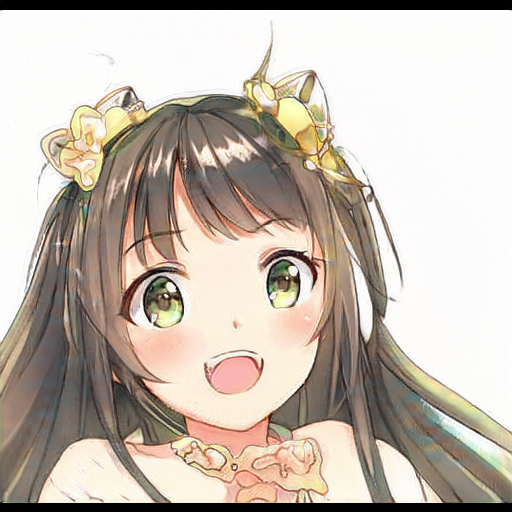

In [ ]:
def createOneImage():
  seed = np.random.randint(10000000, size = 1)
  print(seed)

  # Our key variable to tweak
  psi = .7

  zs = generate_z_vectors_from_seeds(seed)
  imgs = generate_images(zs, psi)
  w = 512
  h = 512
  canvas = PIL.Image.new('RGBA', (w,h), 'white')
  image = imgs[0].resize((w,h), PIL.Image.ANTIALIAS)
  canvas.paste(image)
  return canvas

createOneImage()


In [ ]:
from os import posix_fadvise
from math import ceil

def createImageGrid(rows=1, scale=0.5, size = 9, psi = 0.7):
    # Generate images
    seeds = np.random.randint(10000000, size= size)
    print(seeds)

    psi = psi
    zs = generate_z_vectors_from_seeds(seeds)
    images = generate_images(zs, psi)

    # Display images in a grid
    w,h = images[0].size
    w = int(w*scale)
    h = int(h*scale)
    height = rows*h
    cols = ceil(len(images) / rows)
    width = cols*w
    canvas = PIL.Image.new('RGBA', (width,height), 'blue')
    for i,img in enumerate(images):
      img = img.resize((w,h), PIL.Image.ANTIALIAS)
      canvas.paste(img, (w*(i % cols), h*(i // cols)))
    return canvas

createImageGrid(3, 0.5, 9, .7)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
def saveImages(size = 10, folder = ""):
  seeds = np.random.randint(10000000, size=size)
  print(seeds)

  psi = .7

  zs = generate_z_vectors_from_seeds(seeds)
  imgs = generate_images(zs, psi)
  for index, img in enumerate(imgs):
    img.save(folder + "face_" + str(index+1) + ".png", format="png")

saveImages(512, folder = "/content/gdrive/MyDrive/AnimeFaces/")

In [ ]:
!pip install ipykernel>=5.1.2
!pip install pydeck

     |████████████████████████████████| 4.3 MB 6.9 MB/s 
     |████████████████████████████████| 128 kB 64.0 MB/s 
     |████████████████████████████████| 793 kB 67.2 MB/s 
     |████████████████████████████████| 380 kB 67.5 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 4.10.1
    Uninstalling ipykernel-4.10.1:
      Successfully uninstalled ipykernel-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
lucid 0.3.10 requires nump

In [ ]:
!pip install streamlit

import streamlit as st
from PIL import Image
import random
import glob

# Load the photos
def load_images():
  image_list = []
  for filename in glob.glob('/content/gdrive/MyDrive/AnimeFaces/*.png'):
    image_list.append(filename)
  return image_list

# Load list from state
if 'image_list' not in st.session_state:
  image_list = load_images()
  st.session_state['image_list'] = image_list
else:
  image_list = st.session_state['image_list']

# Make the page itself
st.header("Infinite Anime Characters")

def get_face(image_list):
  if len(image_list) < 1:
    image_list = load_images()
    st.session_state['image_list'] = image_list

  new_face = random.choice(image_list)
  image = Image.open(new_face)

  image_list.remove(new_face)
  st.image(image, caption="")

st.button("Get a new face", key=None, help=None, on_click=get_face(image_list), args=None, kwargs=None)

In [ ]:
!streamlit run webapp.py &>/dev/null&

In [ ]:
!pip install pyngrok

In [ ]:
ngrok.set_auth_token("22sz17zKO2jeGilC34OUGFd5AF4_2DKvJ5Rd7LWzxjpEmHgXE")


In [ ]:
from pyngrok import ngrok
!killall ngrok
public_url = ngrok.connect(8501)
public_url